<h1><center>TESLA Tutorial</center></h1>


<center>Author: Jian Hu*,  Kyle Coleman, Edward B. Lee, Humam Kadara, Linghua Wang*, Mingyao Li*

## Outline
#### 1. Installation
#### 2. Import modules
#### 3. Read in data
#### 4. Gene expression enhancement
#### 5. Region annotation
#### 6. Characterize the intra-tumor heterogeneity
#### 7. TLS detection

### 1. Installation
To install TESLA package you must make sure that your python version is over 3.5.=. If you don’t know the version of python you can check it by:

In [7]:
import platform
platform.python_version()

'3.8.8'

Note: Because TESLA pends on pytorch, you should make sure torch is correctly installed.
<br>
Now you can install the current release of TESLA by the following three ways:
#### 1.1 PyPI: Directly install the package from PyPI.

In [ ]:
pip3 install TESLAforST
#If you do not have permission (when you get a permission denied error), you should install TESLA by
pip3 install --user TESLAforST

#### 1.2 Github
Download the package from Github and install it locally:

In [2]:
git clone https://github.com/jianhuupenn/TESLA
cd ./TESLA/TESLA_package/
python3 setup.py install --user

#### 1.3 Anaconda ()
If you do not have Python3.5 or Python3.6 installed, consider installing Anaconda (see Installing Anaconda). After installing Anaconda, you can create a new environment, for example, TESLA (you can change to any name you like).

In [3]:
#create an environment called TESLA
conda create -n TESLA python=3.7.9
#activate your environment 
conda activate TESLA
git clone https://github.com/jianhuupenn/TESLA
cd TESLA/TESLA_package/
python3 setup.py build
python3 setup.py install
conda deactivate

### 2. Import python modules

In [38]:
import os,csv,re, time
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import issparse
import scanpy as sc
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import cv2
import TESLA as tesla
from IPython.display import Image

In [2]:
tesla.__version__

'1.0.0'

### 3. Read in data
The current version of TESLA requres three input data: 
<br>
1. The gene expression matrix(n by k): expression_matrix.h5;
<br>
2. Spatial coordinateds of samplespositions.txt;
<br>
3. Histology image(optional): histology.tif, can be tif or png or jepg.
<br>
The gene expreesion data can be stored as an AnnData object. AnnData stores a data matrix .X together with annotations of observations .obs, variables .var and unstructured annotations .uns. 

In [3]:
"""
#Read original 10x_h5 data and save it to h5ad
from scanpy import read_10x_h5
adata = read_10x_h5("../tutorial/data/151673/expression_matrix.h5")
spatial=pd.read_csv("../tutorial/data/151673/positions.txt",sep=",",header=None,na_filter=False,index_col=0) 
adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("../tutorial/data/151673/sample_data.h5ad")
"""
#Read in gene expression and spatial location
counts=sc.read("./data/sample_data.h5ad")
#Read in hitology image
img=cv2.imread("./data/sample_H&E.jpg")

### 4. Gene expression enhancement

#### 4.1 Preprocessing

In [5]:
resize_factor=1000/np.min(img.shape[0:2])
resize_width=int(img.shape[1]*resize_factor)
resize_height=int(img.shape[0]*resize_factor)
counts.var.index=[i.upper() for i in counts.var.index]
counts.var_names_make_unique()
counts.raw=counts
sc.pp.log1p(counts) # impute on log scale
if issparse(counts.X):counts.X=counts.X.A

#### 4.2 Contour detection

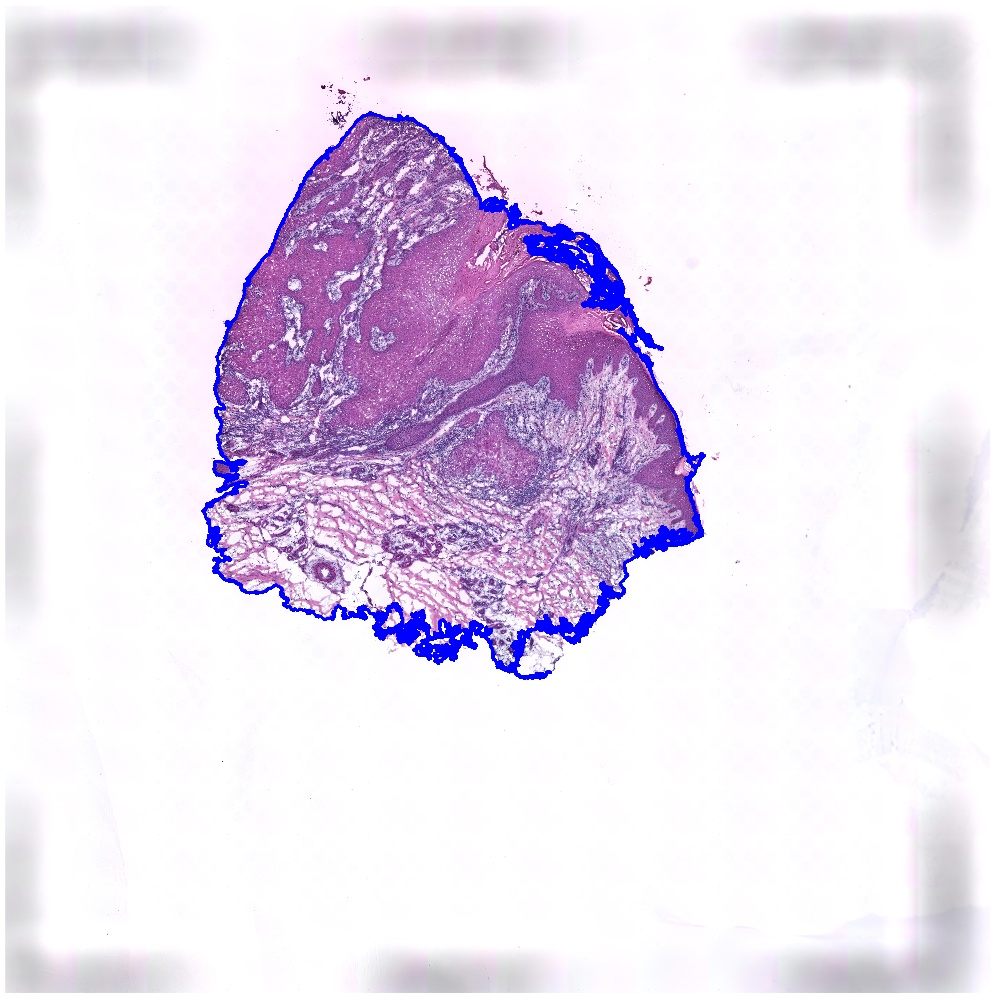

In [6]:
#Three different algorithms to detect contour, select the best one.Here we use cv2.

#-----------------1. Detect contour using cv2-----------------
cnt=tesla.cv2_detect_contour(img, apertureSize=5,L2gradient = True)

#-----------------2. Scan contour by x-----------------
spots=counts.obs.loc[:, ['pixel_x', 'pixel_y', "array_x", "array_y"]]
#shape="hexagon" for 10X Vsium, shape="square" for ST
cnt=tesla.scan_contour(spots, scan_x=True, shape="hexagon")

#-----------------3. Scan contour by y-----------------
spots=counts.obs.loc[:, ['pixel_x', 'pixel_y', "array_x", "array_y"]]
#shape="hexagon" for 10X Vsium, shape="square" for ST
cnt=tesla.scan_contour(spots, scan_x=False, shape="hexagon")

binary=np.zeros((img.shape[0:2]), dtype=np.uint8)
cv2.drawContours(binary, [cnt], -1, (1), thickness=-1)
#Enlarged filter
cnt_enlarged = tesla.scale_contour(cnt, 1.05)
binary_enlarged = np.zeros(img.shape[0:2])
cv2.drawContours(binary_enlarged, [cnt_enlarged], -1, (1), thickness=-1)
img_new = img.copy()
cv2.drawContours(img_new, [cnt], -1, (255), thickness=50)
img_new=cv2.resize(img_new, ((resize_width, resize_height)))
cv2.imwrite('./results/cnt.jpg', img_new)
Image(filename='./results/cnt.jpg')

#### 4.3 Gene expression enhancement

In [12]:
#Set size of superpixel
res=50
# Note, if the numer of superpixels is too large and take too long, you can increase the res to 100
enhanced_exp_adata=tesla.imputation(img=img, raw=counts, cnt=cnt, genes=counts.var.index.tolist(), shape="None", res=res, s=1, k=2, num_nbs=10)

Trying to set attribute `.obs` of view, copying.


Total number of sudo points:  19988
Calculating spot 0
Calculating spot 1000
Calculating spot 2000
Calculating spot 3000
Calculating spot 4000
Calculating spot 5000
Calculating spot 6000
Calculating spot 7000
Calculating spot 8000
Calculating spot 9000
Calculating spot 10000
Calculating spot 11000
Calculating spot 12000
Calculating spot 13000
Calculating spot 14000
Calculating spot 15000
Calculating spot 16000
Calculating spot 17000
Calculating spot 18000
Calculating spot 19000
--- 76.97813606262207 seconds ---
Imputing spot 0
Imputing spot 1000
Imputing spot 2000
Imputing spot 3000
Imputing spot 4000
Imputing spot 5000
Imputing spot 6000
Imputing spot 7000
Imputing spot 8000
Imputing spot 9000
Imputing spot 10000
Imputing spot 11000
Imputing spot 12000
Imputing spot 13000
Imputing spot 14000
Imputing spot 15000
Imputing spot 16000
Imputing spot 17000
Imputing spot 18000
Imputing spot 19000


#### 4.4 Plot  gene expression image

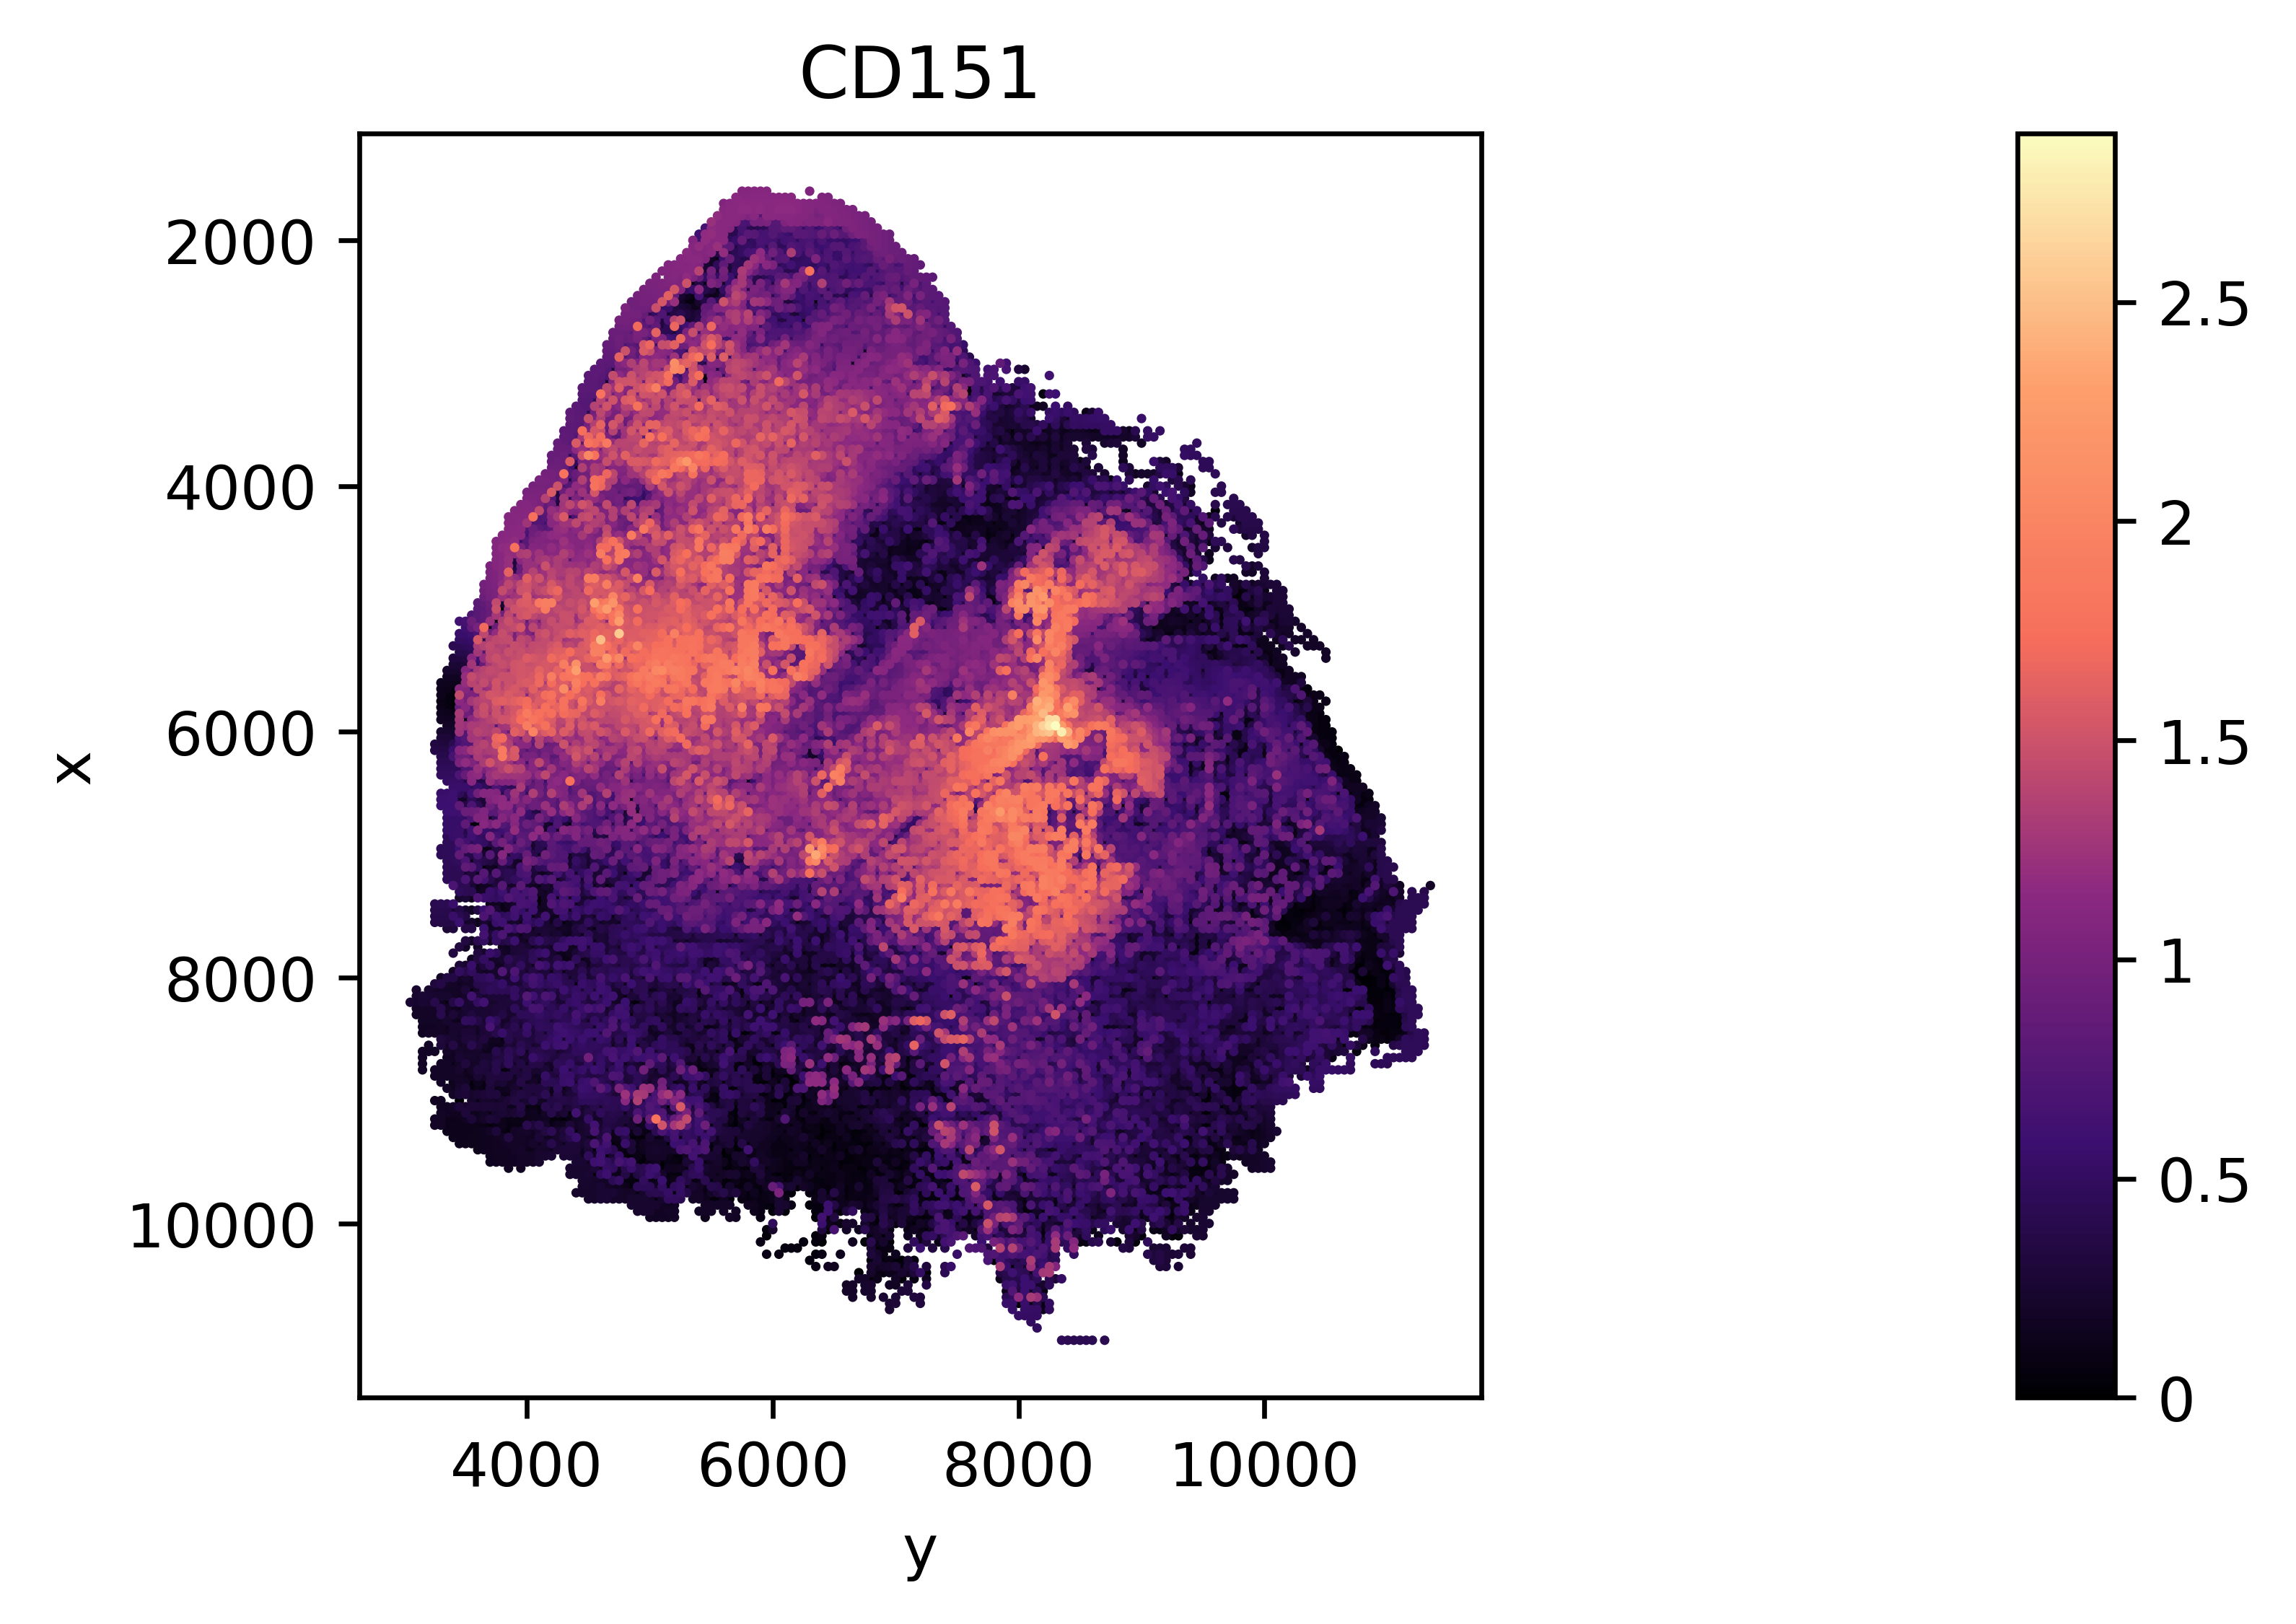

In [17]:
cnt_color = clr.LinearSegmentedColormap.from_list('magma', ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"], N=256)
g="CD151"
enhanced_exp_adata.obs[g]=enhanced_exp_adata.X[:,enhanced_exp_adata.var.index==g]
fig=sc.pl.scatter(enhanced_exp_adata,alpha=1,x="y",y="x",color=g,color_map=cnt_color,show=False,size=10)
fig.set_aspect('equal', 'box')
fig.invert_yaxis()
plt.gcf().set_dpi(600)
fig.figure.show()

#### 4.5 Save results

In [14]:
enhanced_exp_adata.write_h5ad("./results/enhanced_exp.h5ad")

### 5. Region annotation

#### 5.1 Target region annotation

Computing image band...
Computing gene band...
Running TESLA...
0 / 30 |  label num : 100 |  main clusters : 65  | feature loss : 6.286277770996094  | spatial loss : 2.477134943008423
--- 79.8510057926178 seconds ---
1 / 30 |  label num : 75 |  main clusters : 30  | feature loss : 4.300119400024414  | spatial loss : 0.44662031531333923
--- 136.36640787124634 seconds ---
mainLabels 30 reached minLabels 30 .
Finding target clusters...
c_m:
[(6, 0.660496668592895), (2, 0.5849543163588522), (15, 0.5158497030203698), (19, 0.48606369815923994), (12, 0.4802130752317957), (10, 0.4580134991936973), (4, 0.45732190334046835), (14, 0.43235966925018005), (17, 0.3388222879213612), (13, 0.3331709370762233), (16, 0.3160079580858375), (9, 0.2478758789018975), (8, 0.21917223597411475), (7, 0.20651287130232146), (3, 0.19796864337328288), (11, 0.19742332922793465), (20, 0.15788060926103378), (1, 0.14535831267938887), (5, 0.1265518524797657), (18, 0.024549401709053432), (0, 0.0)]
Target clusters:
[6, 2, 15

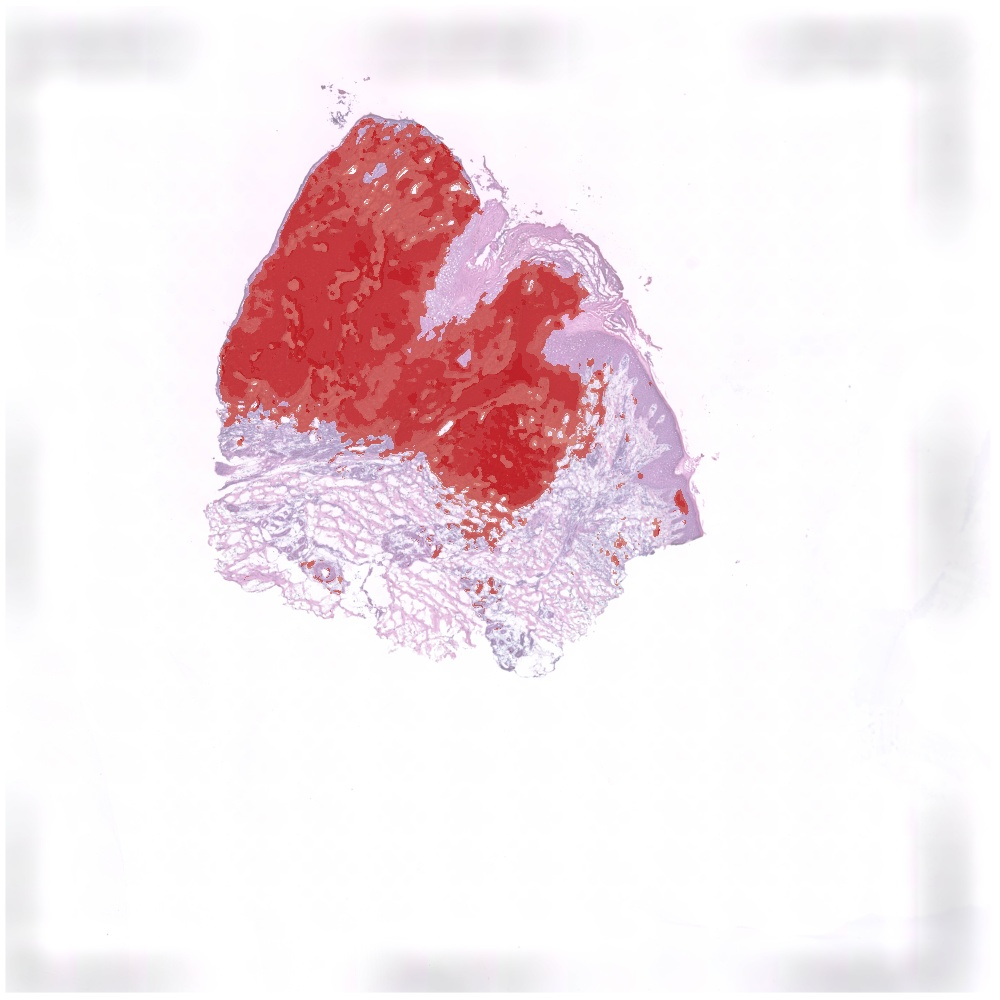

In [32]:
#Select your gene list
#For example, if we want to annotate tumor region, use tumor markers
genes=['BUB1B', 'KIF1C','TOP2A', 'CD151', 'MMP10', 'PTHLH','FEZ1','IL24','KCNMA','INHBA','MAGEA4','NT5E','LAMC2','SLITRK6']
genes=list(set([i for i in genes if i in enhanced_exp_adata.var.index ]))
pred_refined, target_clusters, c_m=tesla.annotation(img=img, 
                                                    binary=binary,
                                                    sudo_adata=enhanced_exp_adata, 
                                                    genes=genes, 
                                                    resize_factor=resize_factor)
#Plot
ret_img=tesla.plot_annotation(img=img, 
                              binary=binary, 
                              resize_factor=resize_factor,
                              pred_refined=pred_refined, 
                              target_clusters=target_clusters, 
                              c_m=c_m)

cv2.imwrite('./results/tumor.jpg', ret_img)
Image(filename='./results/tumor.jpg')

#### 5.2 Save results

In [29]:
#Save
np.save("./results/tumor_annotation.npy", pred_refined)
print("Target_clusters: ", target_clusters, "\n")
print("c_m: ", c_m)

Target_clusters:  [6, 2, 15, 19, 12, 10, 4, 14, 17, 13] 

c_m:  [(6, 0.660496668592895), (2, 0.5849543163588522), (15, 0.5158497030203698), (19, 0.48606369815923994), (12, 0.4802130752317957), (10, 0.4580134991936973), (4, 0.45732190334046835), (14, 0.43235966925018005), (17, 0.3388222879213612), (13, 0.3331709370762233), (16, 0.3160079580858375), (9, 0.2478758789018975), (8, 0.21917223597411475), (7, 0.20651287130232146), (3, 0.19796864337328288), (11, 0.19742332922793465), (20, 0.15788060926103378), (1, 0.14535831267938887), (5, 0.1265518524797657), (18, 0.024549401709053432), (0, 0.0)]


### 6. Characterize the intra-tumor heterogeneity

#### 6.1 Read in saved results

In [15]:
enhanced_exp_adata=sc.read("./results/enhanced_exp.h5ad")
pred_refined=np.load("./results/tumor_annotation.npy")
target_clusters=[6, 2, 15, 19, 12, 10, 4, 14, 17, 13]
c_m= [(6, 0.660496668592895), (2, 0.5849543163588522), (15, 0.5158497030203698), (19, 0.48606369815923994), (12, 0.4802130752317957), (10, 0.4580134991936973), (4, 0.45732190334046835), (14, 0.43235966925018005), (17, 0.3388222879213612), (13, 0.3331709370762233), (16, 0.3160079580858375), (9, 0.2478758789018975), (8, 0.21917223597411475), (7, 0.20651287130232146), (3, 0.19796864337328288), (11, 0.19742332922793465), (20, 0.15788060926103378), (1, 0.14535831267938887), (5, 0.1265518524797657), (18, 0.024549401709053432), (0, 0.0)]

#### 6.2 Leading edge detection

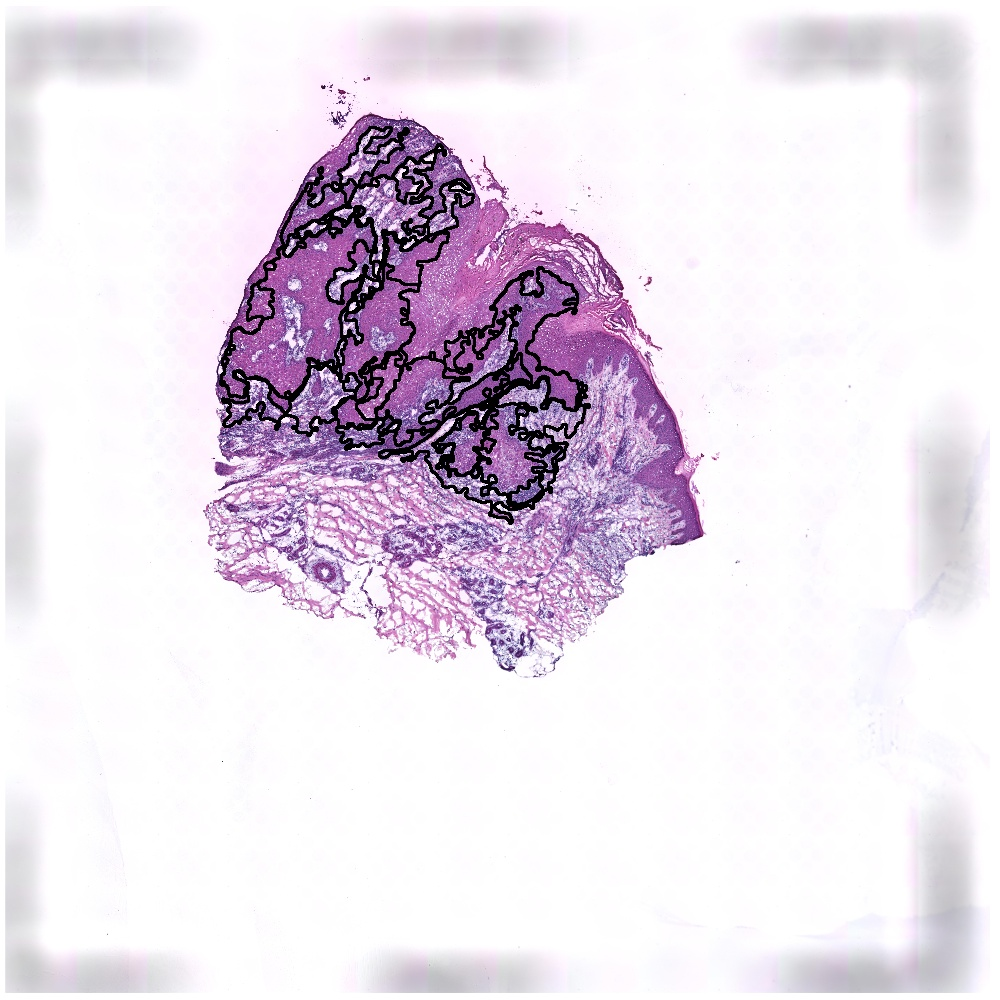

In [9]:
ret_img=tesla.leading_edge_detection(img=img, 
                                     pred_refined=pred_refined, 
                                     resize_factor=resize_factor, 
                                     target_clusters=target_clusters, 
                                     binary=binary)

cv2.imwrite('./results/leading_edge.jpg', ret_img)
Image(filename='./results/leading_edge.jpg')

#### 6.3 Tumor edge and core separation

Running Connected Components ...
Running Select biggest Tumor region ...
Running Core and edge separation ...
Running Create Gene Expression adata for tumor edge vs. core ...


Trying to set attribute `.obs` of view, copying.


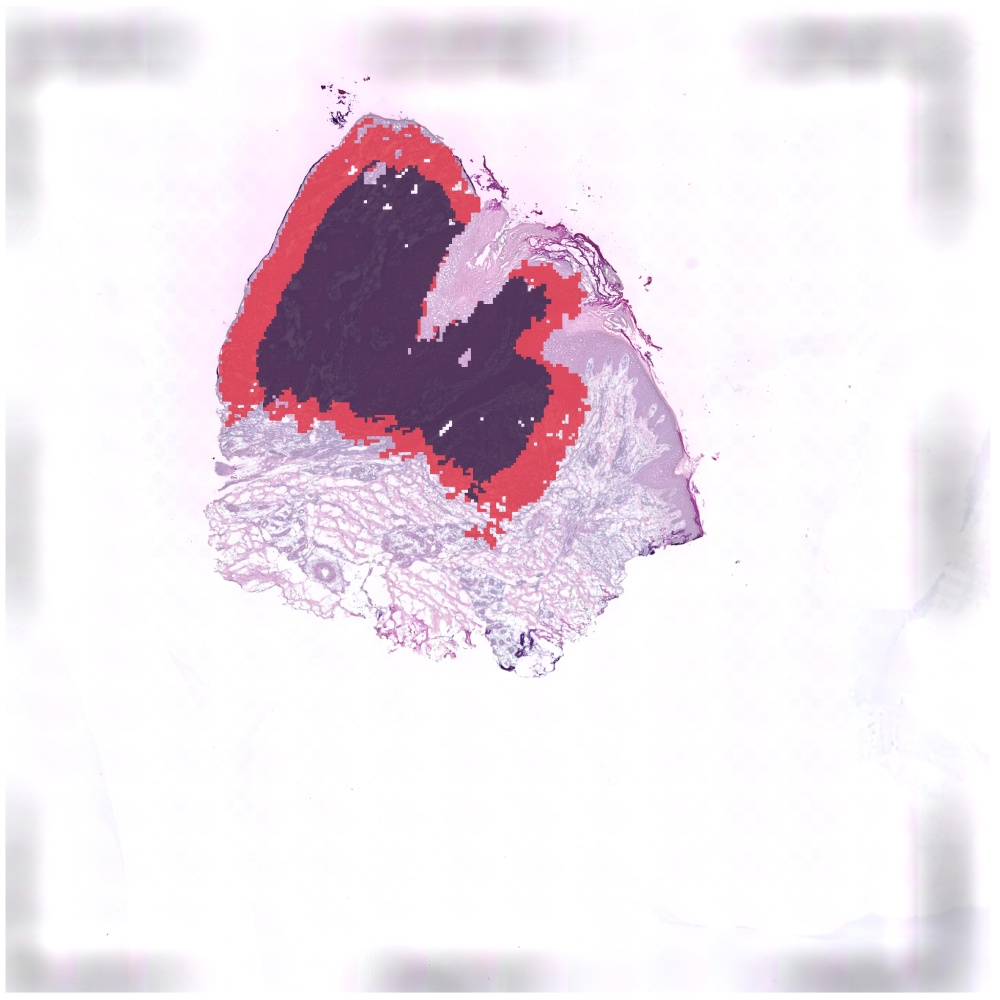

In [16]:
shrink_rate=0.8
res=50
binary_tumor, binary_core, core_edge_exp=tesla.tumor_edge_core_separation(img=img, 
                                                                           binary=binary,
                                                                           resize_factor=resize_factor, 
                                                                           pred_refined=pred_refined, 
                                                                           target_clusters=target_clusters, 
                                                                           sudo_adata=enhanced_exp_adata, 
                                                                           res=res, 
                                                                           shrink_rate=shrink_rate)

ret_img=tesla.plot_tumor_edge_core(img=img, 
                                   resize_factor=resize_factor, 
                                   binary=binary, 
                                   binary_tumor=binary_tumor, 
                                   binary_core=binary_core, 
                                   color_edge=[66, 50, 225], 
                                   color_core=[62, 25, 53])

cv2.imwrite('./results/core_edge.jpg', ret_img)
Image(filename='./results/core_edge.jpg')

#### 6.4. Core vs core DE analysis

In [18]:
df_core, df_edge=tesla.tumor_edge_core_DE(core_edge_exp)
df_edge_filtered=tesla.filter_DE_genes(df=df_edge, min_all_mean_exp=0.1, min_in_out_group_ratio=1, min_in_group_fraction=0.5, min_fold_change=1.2)
df_core_filtered=tesla.filter_DE_genes(df=df_core, min_all_mean_exp=0.1, min_in_out_group_ratio=1, min_in_group_fraction=0.5, min_fold_change=1.2)
df_edge_filtered

,edge_genes,in_group_fraction,out_group_fraction,in_out_group_ratio,in_group_mean_exp,out_group_mean_exp,fold_change,pvals_adj,all_mean_exp
B3GALT4,B3GALT4,0.887826,0.730257,1.215772,0.159630,0.099114,1.610570,1.289481e-90,0.121456
RHOF,RHOF,0.825470,0.637768,1.294311,0.168203,0.112965,1.488977,9.696451e-66,0.133358
DMXL2,DMXL2,0.924777,0.792817,1.166445,0.187402,0.127881,1.465440,2.114505e-65,0.149855
PTGDS,PTGDS,0.774992,0.621162,1.247648,0.194328,0.110119,1.764701,2.475420e-64,0.141208
FYB,FYB,0.933355,0.858274,1.087480,0.325664,0.229077,1.421633,4.381763e-64,0.264736
...,...,...,...,...,...,...,...,...,...
ZBTB18,ZBTB18,0.837017,0.834331,1.003220,0.136065,0.108772,1.250920,1.998338e-07,0.118848
TMEM176A,TMEM176A,0.798086,0.795713,1.002982,0.175890,0.139969,1.256630,1.528395e-06,0.153230
ARMC7,ARMC7,0.863411,0.839930,1.027956,0.144560,0.119669,1.207997,3.360836e-06,0.128859
PTAFR,PTAFR,0.780271,0.770805,1.012280,0.203142,0.168537,1.205324,4.606770e-04,0.181313


#### 6.5. Plot core/edge enriched genes

In [23]:
cnt_color = clr.LinearSegmentedColormap.from_list('magma', ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"], N=256)
genes=["IGFBP2", "CXCL12"]
plot_dir="./results/"
tesla.plot_edge_core_enrichd_genes(img=img, 
                                   resize_factor=resize_factor,
                                   binary=binary, 
                                   binary_tumor=binary_tumor, 
                                   sudo_core_edge=core_edge_exp,
                                   genes=genes, 
                                   cnt_color=cnt_color, 
                                   plot_dir=plot_dir, 
                                   res=res)


### 6.6 Plot ome examples

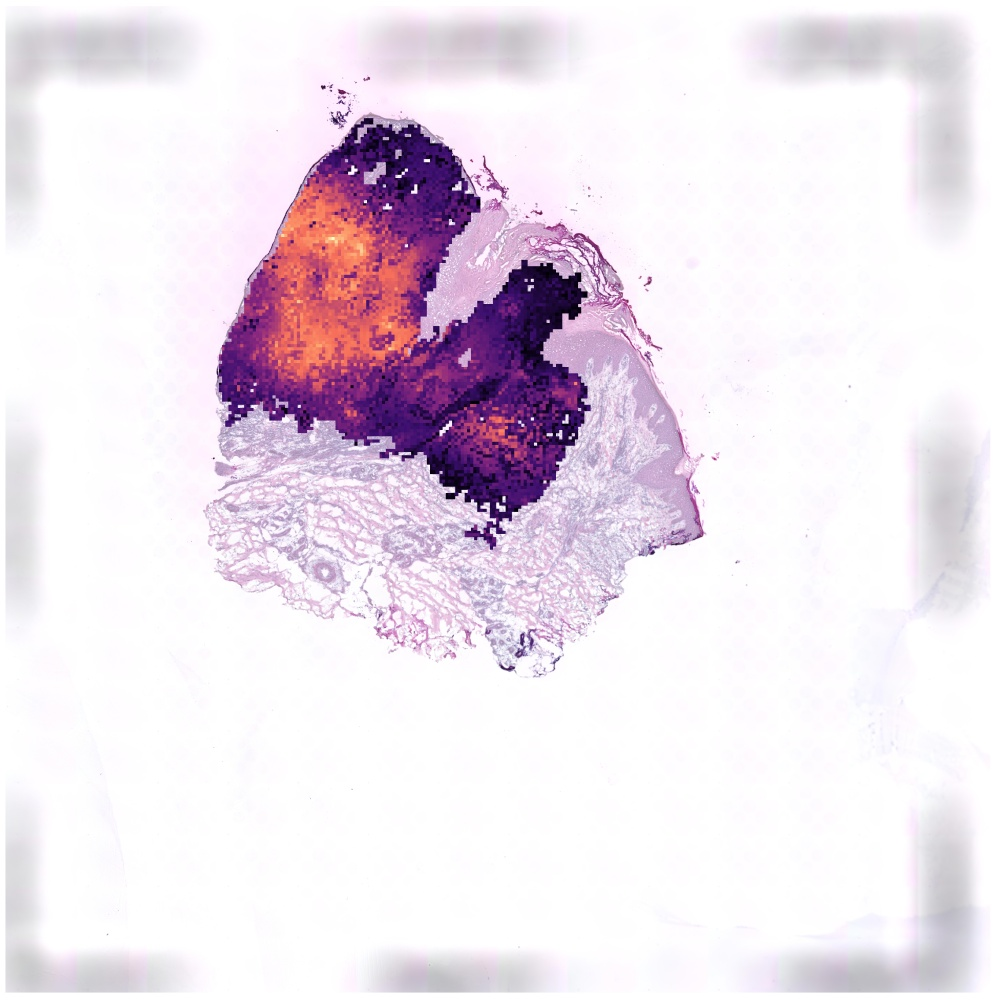

In [25]:
# Core enriched gene
Image(filename='./results/IGFBP2.jpg')

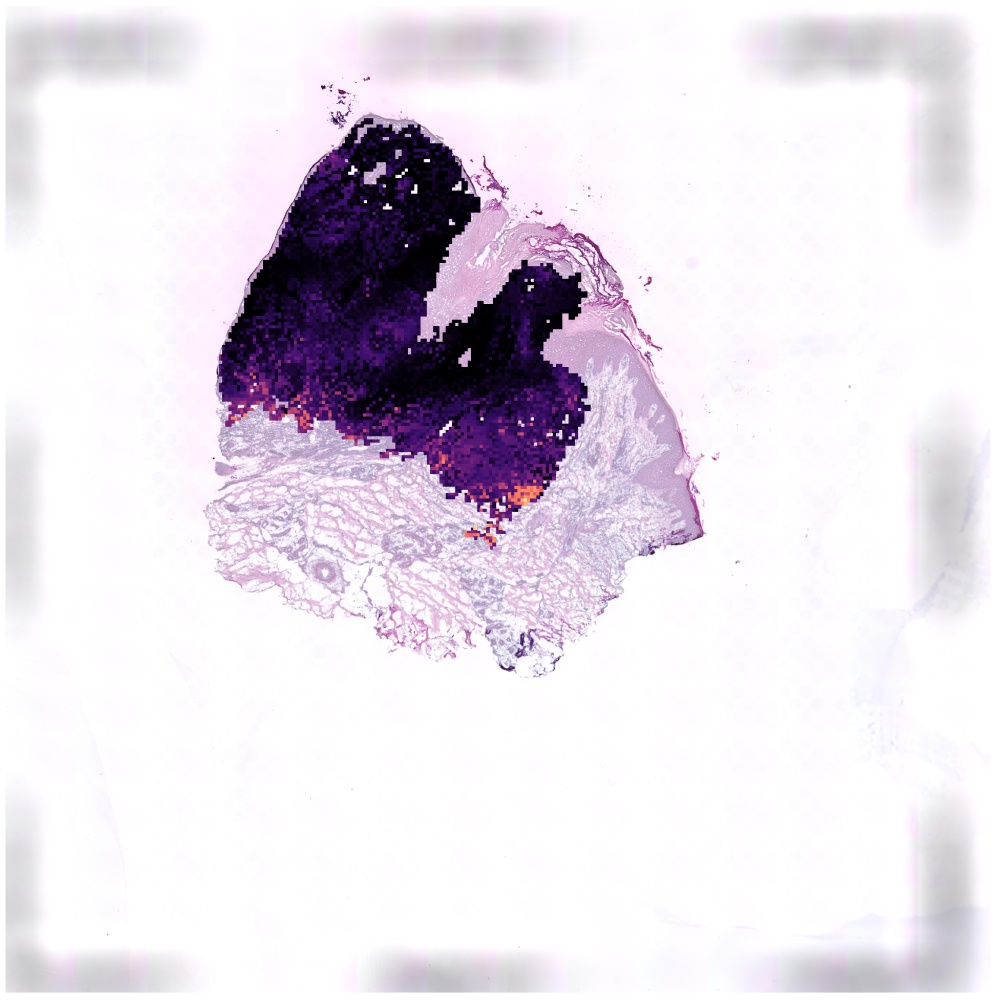

In [26]:
# Edge enriched gene
Image(filename='./results/CXCL12.jpg')

### 7. TLS detection

#### 7.1 Read in cell type annotations
##### Before runing TLS detection, please detect B, CD4+T, DC and CXCL13.

In [31]:
#---------------------------------1. TLS detection ----------------------------------#
cnt_color = clr.LinearSegmentedColormap.from_list('red', ["#EAE7CC", '#BA0000'], N=256)
pred_refined1=np.load("./results/B_annotation.npy")
pred_refined2=np.load("./results/CD4+T_annotation.npy")
pred_refined3=np.load("./results/DC_annotation.npy")
pred_refined4=np.load("./results/CXCL13_annotation.npy")
pred_refined_list=[pred_refined1, pred_refined2, pred_refined3, pred_refined4]

#### 7.2 Calculate TLS score

In [36]:
cluster_density_list=[{9: 0.3475183859247766, 8: 0.20281905545654758},
                      {9: 0.36923992651041304, 5: 0.2798717703860183},
                      {10: 0.4262578289741636},
                      {9: 0.4466834992921865, 7: 0.3339196160263545, 13: 0.2764052169986122, 5: 0.22543481792572062}]

cnt_color = clr.LinearSegmentedColormap.from_list('red', ["#EAE7CC", '#BA0000'], N=256)
num_required=3
tls_score=tesla.TLS_detection(pred_refined_list, cluster_density_list, num_required, cnt_color)
img_tls=teslaplot_TLS_score(img, resize_factor, binary,tls_score, cnt_color)

#### 7.3 Plot TLS score

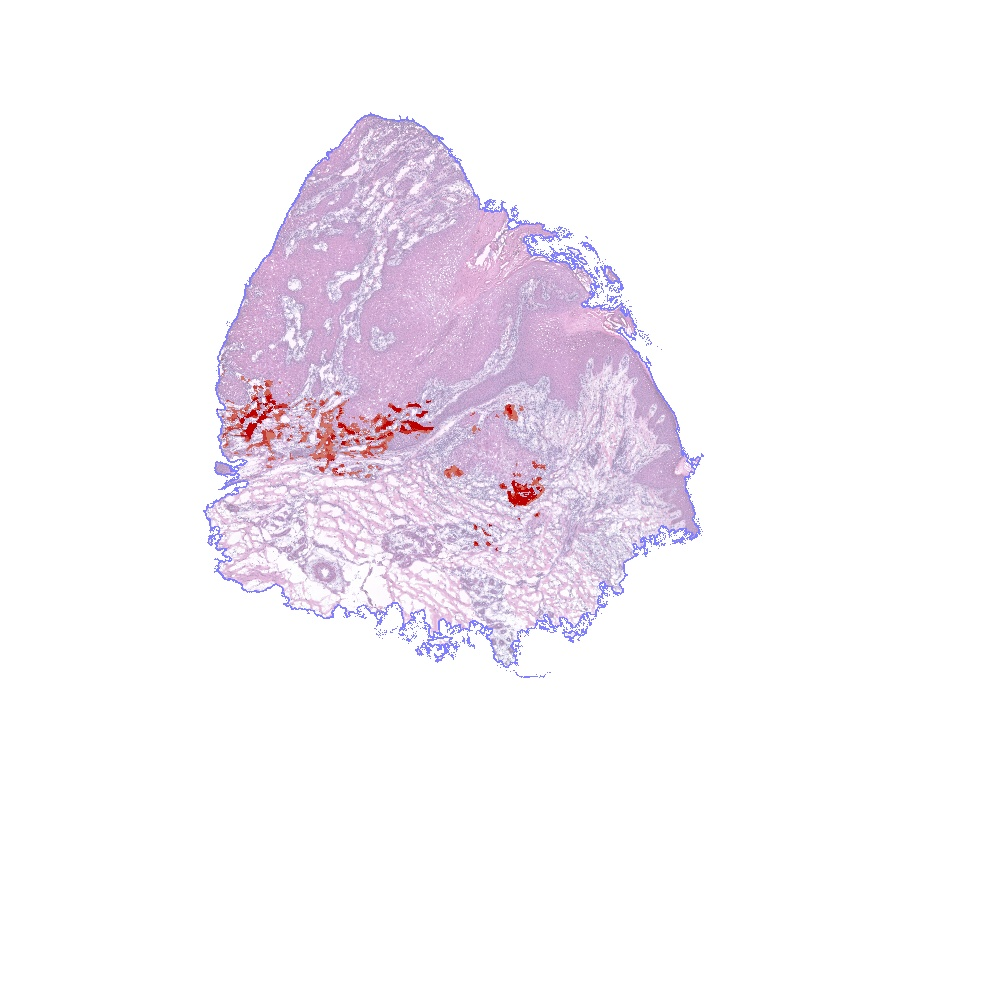

In [37]:
cv2.imwrite('./results/TLS_score.jpg', img_tls)
Image(filename='./results/TLS_score.jpg')